Reading the first column for dates
Didn't find a parseable date in row  1 :  Not updated
Didn't find a parseable date in row  9 :  Visit Date
Didn't find a parseable date in row  349 :  Tina added
Didn't find a parseable date in row  653 :  S+10:653ep 14, 2017
data runs from row  11  to  862
Found  135  rows, with  61  cells to examine, for month  8
Keywords and counts found: [('synergy', 23), ('simplivity', 14), ('iot', 13), ('aruba', 9), ('azurestack', 8), ('oneview', 8), ('3par', 7), ('edgeline', 6), ('hybrid', 6), ('pointnext', 5), ('nimble', 5), ('arista', 4), ('analytics', 4), ('composable', 4), ('sap', 4), ('gen10', 4), ('new_stack', 3), ('vdi', 3), ('clearpass', 3), ('apollo', 3), ('cloudcruiser', 3), ('hyperconverged', 3), ('the_machine', 3), ('wireless', 2), ('helion', 2), ('meridian', 2), ('smart_city', 2), ('sgi', 2), ('flex_capacity', 2), ('pathfinder', 1), ('superdome', 1), ('docker', 1), ('devops', 1), ('blockchain', 1), ('storeonce', 1), ('blades', 1), ('moonshot', 1)]


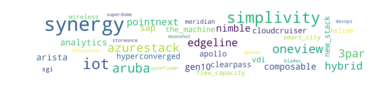

In [2]:
## Function to extract the column data into a dict, indexed by row, ignoring empty cells
def get_column_to_dict(sheet,col,first_row,last_row):
    col_values=dict()
    for row in range(first_row_with_data,last_row_with_data):
        val=sheet.cell(row=row,column=col).value
        if (val is not None): col_values[row]=val.lower()            
    return col_values

## Add up down all the columns of an MxN array, returning a 1xN array of the result
def sumColumns(m):
    return [sum(col) for col in zip(*m)][0]


## Start by reading in the Excel spreadsheet - Insights.xlsx
from openpyxl import Workbook
import openpyxl
book = openpyxl.load_workbook('Insights.xlsx')
sheet = book.active

## Now read in the dates column
from datetime import datetime
print("Reading the first column for dates")
row_date=dict()
first_row_with_data=0
last_row_with_data=0
#extract the dates into a dict, indexed by row, noting first and last rows with valid data
for row in range(1,2000):
    val=sheet.cell(row=row,column=1).value
    if (val is not None):
        #try and convert to date
        try:
            if (type(val) is datetime):
                dateval = val   # cell is already in date format, so just use it
            else:
                dateval = datetime.strptime(val,"%b %d, %Y")   # parse the values (in the format we seem to have) into a date
            row_date[row]=dateval
            if (first_row_with_data==0): first_row_with_data=row
            else: last_row_with_data=row
        except ValueError:
            print("Didn't find a parseable date in row ",row,": ",val)
        except TypeError:
            print("Type error on row ",row," for value ",val," of type ",type(val))
                
print("data runs from row ",first_row_with_data," to ",last_row_with_data)

## Extract non-empty values of column 13, "Want To Learn More About", into a dict, indexed by row
learn_more_about = get_column_to_dict(sheet,13,first_row_with_data,last_row_with_data)   

## Extract non-empty values of col 18, "Action Items", into a dict, indexed by row
action_items = get_column_to_dict(sheet,18,first_row_with_data,last_row_with_data) 

## Find all the text we will use from any row with given month's date
month_to_use = 8
rows_in_month=0
comments_to_search = []
for r,d in row_date.items():
    if (d.date().month == month_to_use):
        rows_in_month+=1
        newitem=""
        if (r in learn_more_about): newitem=learn_more_about[r]
        if (r in action_items): newitem=newitem+" "+action_items[r]
        if (newitem!=""): comments_to_search.append(newitem)
print("Found ",rows_in_month," rows, with ",len(comments_to_search)," cells to examine, for month ",month_to_use)

replace_text={
    "/": " ",
    "\n": " ",
    "big data": "big_data",
    "new stack": "new_stack",
    "flexible capacity": "flex_capacity",
    "gen 10": "gen10",
    "gen z": "gen-z",
    "cloud cruiser": "cloudcruiser",
    "store once": "storeonce",
    "smart city": "smart_city",
    "future city": "smart_city",
    "azure stack": "azurestack",
    "intelligent edge": "edgeline",
    "clear pass": "clearpass",
    "one view": "oneview",
    "the machine": "the_machine",
    "open stack": "openstack",
    "store once": "storeonce",
    "office 365": "office365",
    "hp financial services" "hpefs"
    "hpe financial services": "hpefs",
    "hpfs": "hpefs",
    "integrity": "superdome",
    "mobility": "wireless"
}

for i, val in enumerate(comments_to_search):
    updated_item=comments_to_search[i]
    #if (updated_item.find("the machine") != -1): print("found <the machine> in row ",i," - ",updated_item[:60])
    for k,v in replace_text.items():
        updated_item=updated_item.replace(k,v)    
    comments_to_search[i]=updated_item

#print("First few texts found for month ",month_to_use,":\n",comments_to_search[:5])

#use this specific set of words as the vocab to look for
vocab=["iot","edgeline","smart_city", "big_data","sap","apollo", "saas", "analytics", "sgi", "networking", "wireless", "aruba",
       "arista", "clearpass", "naas", "skype", "meridian", "airwave","composable", "niara", "flex_capacity", "helion",
       "azurestack","synergy","moonshot","converged","hyperconverged","hybrid","docker","vdi","new_stack","cloudline",
       "cloudsystem","easyconnect","openstack","devops","3par","bura","simplivity","nimble","scality","storeonce",
       "oneview", "office365","pointnext","hpefs","the_machine","photonics","blockchain","pathfinder","gen10","gen-z",
       "cloudcruiser","blades","superdome"
      ]

#do the conversion to tf-idf, ignoring English stop words  
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=30,
                             min_df=2,
                             vocabulary=vocab,
                             binary=True   # This means the term freqency of any given word in an item is 0 (doesn't occur) or 1 (does, regardless of how often)
                            )
#This next line builds the documents x features matrix, using the vectorizer we've created
X = vectorizer.fit_transform(comments_to_search)

# Now turn the idfs into a dict, mapping "word" to idf 
dict_of_words_to_freq={}
col_sums = sumColumns(X)
for keyword,idx in vectorizer.vocabulary_.items():
    if col_sums[0,idx]>0:
        dict_of_words_to_freq[keyword]=col_sums[0,idx]
        #print(" keyword =",keyword," freq =",col_sums[0,idx])
    
import operator
sorted_list = sorted(dict_of_words_to_freq.items(), key=operator.itemgetter(1),reverse=True)
print("Keywords and counts found:", sorted_list)


##Build a wordcloud, using the wordcloud code from Andreas Mueller
# (to install, run "pip install wordcloud")
from wordcloud import WordCloud
import random

#Generate the wordcloud
wordcloud= WordCloud(width=2500,height=500,
                     prefer_horizontal=0.9,
                     relative_scaling=0.5,
                     max_font_size=144,
                     background_color="white"
                    ).generate_from_frequencies(dict_of_words_to_freq)
# Display the generated image
import matplotlib.pyplot as plt
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.show()
plt.imsave("wordcloud-test.png",wordcloud,format="png")

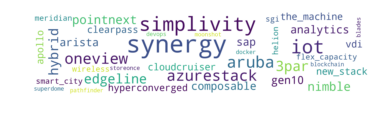

[('synergy', 1.0), ('simplivity', 0.60869565217391308), ('iot', 0.56521739130434778), ('aruba', 0.39130434782608697), ('oneview', 0.34782608695652173), ('azurestack', 0.34782608695652173), ('3par', 0.30434782608695654), ('hybrid', 0.2608695652173913), ('edgeline', 0.2608695652173913), ('pointnext', 0.21739130434782608), ('nimble', 0.21739130434782608), ('analytics', 0.17391304347826086), ('gen10', 0.17391304347826086), ('composable', 0.17391304347826086), ('arista', 0.17391304347826086), ('sap', 0.17391304347826086), ('the_machine', 0.13043478260869565), ('new_stack', 0.13043478260869565), ('vdi', 0.13043478260869565), ('apollo', 0.13043478260869565), ('cloudcruiser', 0.13043478260869565), ('clearpass', 0.13043478260869565), ('hyperconverged', 0.13043478260869565), ('flex_capacity', 0.086956521739130432), ('wireless', 0.086956521739130432), ('smart_city', 0.086956521739130432), ('meridian', 0.086956521739130432), ('helion', 0.086956521739130432), ('sgi', 0.086956521739130432), ('pathfi

In [83]:
#Install the wordcloud code from Andreas Mueller
#pip install wordcloud
from wordcloud import WordCloud
import random

#Generate the wordcloud
wordcloud= WordCloud(width=2000,height=500,
                     prefer_horizontal=0.9,
                     relative_scaling=0.5,
                     max_font_size=144,
                     background_color="white"
                    ).generate_from_frequencies(dict_of_words_to_freq)
# Display the generated image
import matplotlib.pyplot as plt
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.show()

import operator
sorted_list = sorted(wordcloud.words_.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_list)

In [53]:
s=sumColumns(X).todense()
print(s[0,vectorizer.vocabulary_["the_machine"]])

3


In [47]:
sumColumns.todense()[0,vectorizer.vocabulary_["the_machine"]]


AttributeError: 'function' object has no attribute 'todense'

In [75]:
print(type(wordcloud))

<class 'wordcloud.wordcloud.WordCloud'>


In [49]:
foo=["spam","flam","spam ham","ham"]
for i,v in enumerate(foo):
    foo[i]=v.replace("spam ham","spam_ham")
    if "spam ham" in v:
        print(i)

print(foo)

2
['spam', 'flam', 'spam_ham', 'ham']


In [16]:
comments_to_search[:5]

['List provided to Rep.\nOneView',
 'IoT gaps\nTamr',
 'Arista\nAruba beacons\nHPE aaS (HPe as a Service)\nMobility\nCRM\nBroadband (WiFi)\nBeacons',
 'Mesosphere\nMARA',
 "Synergy, OneView, Aruba\nAruba Mobility AP's"]

In [79]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\freemacl\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [3]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize("looped books mobilize","v"))

looped books mobilize


In [17]:
from openpyxl import Workbook
import openpyxl
book = openpyxl.load_workbook('Insights.xlsx')
sheet = book.active

## Import the dates
from datetime import datetime
print("Reading the first column for dates")
row_dates=[]
first_row_with_data=0
last_row_with_data=0
for row in range(1,2000):
    val=sheet.cell(row=row,column=1).value
    if (val is not None):
        #try and convert to date
        try:
            if (type(val) is datetime):
                dateval = val   # cell is already in date format, so just use it
            else:
                dateval = datetime.strptime(val,"%b %d, %Y")   # parse the value we seem to have into a date
            row_dates.append(dateval)
            #print("Row ",row," is a date with value <",dateval,"> and type ",type(dateval))
            if (first_row_with_data==0): 
                first_row_with_data=row
            else:
                last_row_with_data=row
        except ValueError:
            print("Didn't find a parseable date in row ",row,": ",val)
        except TypeError:
            print("type error on row ",row," for value ",val," of type ",type(val))
                
print("data runs from ",first_row_with_data," to ",last_row_with_data)

Reading the first column for dates
Didn't find a parseable date in row  1 :  Not updated
Didn't find a parseable date in row  9 :  Visit Date
Didn't find a parseable date in row  349 :  Tina added
Didn't find a parseable date in row  653 :  S+10:653ep 14, 2017
data runs from  11  to  862


In [15]:
v=sheet.cell(row=863,column=1).value
print("value is <",v,"> of type ",type(v))

value is < None > of type  <class 'NoneType'>
